<a href="https://colab.research.google.com/github/phoenixfin/general-cnn/blob/master/notebook/Plant_Disease_transfer_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing

## Import some modules

In [0]:
import tensorflow as tf
import numpy as np
import os, random
from google.colab import drive
from matplotlib import pyplot as plt

## Set up kaggle datasets

Install the newest kaggle python module

In [0]:
!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


Mount your Google Drive to access Kaggle API json file.
You can uncomment the code below, run it, follow a link given, give accesss, and copy the verification code. Alternatively, you can just click `Mount Drive` in Files pane.


In [0]:
# drive.mount('/content/drive')

Before run the following code, please create first API Token in your Kaggle account (go to the `My Account` section on profile. Then click on `Create New API Token`). You will obtain ‘kaggle.json’ file. This file has the credentials of your API token for your account. Upload this to your google drive and set the path to `json_path` variable below.

In following block, follow a link given, give access to Google Drive and enter a verification code for the API to work.

In [0]:
json_path = "Colab Notebooks/misc/"

os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/"+json_path

Download the datasets

In [0]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

100% 2.70G/2.70G [01:27<00:00, 32.3MB/s]
100% 2.70G/2.70G [01:27<00:00, 33.2MB/s]


Unzip the downloaded file and remove the zip file

In [0]:
%%capture
!unzip \*.zip  && rm *.zip;

# Set up Model Framework

Just run the following block to define the base framework class for the nerual network to be used 

In [0]:
class TransferConvolutionalNetwork(object):
    hyperparam = {}
    augmentation = {'rescale': 1./255}
    callbacks_list = [
        'no_progresss_stopping', 
        'save_per_epoch', 
        'log_to_csv', 
        'good_result_stopping'
    ]    
            
    def __init__(self):
        self.model = None
            
    def show_summary(self):
        self.model.summary()

    def load(self, path, obj='model'):
        file = 'saved\\'+path
        if obj=='model':
            self.model = tf.keras.models.load_model(file)
        elif obj=='weights_only':
            self.model.load_weights(file+'\\variables\\')
        else:
            print('Load failed. Unknown mode')

    def save(self, filename, obj='model'):
        path = 'saved\\'+filename
        if obj=='model':
            self.model.save(path)
        elif obj=='weights_only':
            self.model.save_weights(path+'\\'+variables)
        else:
            print('Load failed. Unknown mode')        
        
    def set_pretrained_model(self, model_name='InceptionV3', 
                             lastpool='avg', fine_tune_at=None,
                             feature_only=True):
        size = self.hyperparam['input_size']
        self.premodel = getattr(tf.keras.applications, model_name)(
            include_top=not feature_only, 
            input_shape=(size, size, 3),
            pooling=lastpool, 
        )
        self.model = self.premodel
        self.last_output = self.premodel.layers[-1].output        
        if lastpool == None:
            self.last_output = tf.keras.layers.Flatten()(self.last_output) 
        
        self.set_fine_tuning(fine_tune_at)

    def rebase_model(self):
        self.model = self.premodel
        
    def set_last_layer(self, ids=None, mode='name'):
        last_layer = self.premodel.get_layer(**{mode: ids})
        self.last_output = last_layer.output

    def set_fine_tuning(self, fine_tune_at):
        if type(fine_tune_at) == int:
            fine_tune_at = self.premodel.get_layer(index=fine_tune_at).name
        val = False
        count = 0

        for layer in self.premodel.layers:
            if fine_tune_at:
                if layer.name == fine_tune_at: 
                    val = True
            count += int(val)
            layer.trainable = val
        print('trainable layers:', count)
        print('total layers:', len(self.premodel.layers))

    def add_convolution(self, filter_num, kernels_size, 
                        pooling = (2,2), activation = 'relu', 
                        dropout = 0, normalize = False):

        kwargs = {'activation':activation}
        for i, num in enumerate(filter_num):
            kwargs['filters'] = num
            kwargs['kernel_size'] = kernels_size[i]

            x = tf.keras.layers.Conv2D(**kwargs)(self.last_output)
            if pooling: 
                x = tf.keras.layers.MaxPooling2D(*pooling)(x)
            if normalize:
                x = tf.keras.layers.BatchNormalization()(x)

        if dropout:
            x = tf.keras.layers.Dropout(dropout)(x)
        x = tf.keras.layers.Flatten()(x)
        self.last_output = x
        self.model = tf.keras.models.Model(self.model.input, x)
        
    def add_hidden_layers(self, neurons_list, dropout = 0, 
                          normalize = False, activation='relu'):
        x = self.last_output
        for num in neurons_list:
            x = tf.keras.layers.Dense(num, activation=activation)(x)
            if dropout:
                x = tf.keras.layers.Dropout(dropout)(x)
            if normalize:
                x = tf.keras.layers.BatchNormalization()(x)        
        self.last_output = x
        self.model = tf.keras.models.Model(self.model.input, x)        
        
    def set_output_layer(self):
        if self.mode == 'binary':
            activation = 'sigmoid'
        elif self.mode == 'categorical':
            activation = 'softmax'
        out_neurons = self.image_data['train'].num_classes        
        out_layer = tf.keras.layers.Dense(out_neurons, activation=activation)
        x = out_layer(self.last_output)

        self.model = tf.keras.models.Model(self.model.input, x)

    def obtain_image_data(self, path):
        train_dir = path+'/train'
        val_dir = path+'/valid'
                
        IMG = tf.keras.preprocessing.image.ImageDataGenerator

        tg = IMG(**self.augmentation)
        vg = IMG(rescale = 1./255)

        in_ = self.hyperparam['input_size']
        classes = len(os.listdir(train_dir))
        self.mode = 'binary' if classes == 2 else 'categorical'

        train_data = tg.flow_from_directory(
            train_dir,
            batch_size = self.hyperparam['batch_size'],
            class_mode = self.mode,
            target_size = (in_, in_)
        )
        validation_data =  vg.flow_from_directory(
            val_dir,
            batch_size = self.hyperparam['batch_size'],
            class_mode = self.mode,
            target_size = (in_, in_)
        )
        self.image_data = {'train':train_data, 'val':validation_data}

    def set_callbacks(self, cb_list):
        callbacks = []
        CB = tf.keras.callbacks

        # no progress stopping callback
        if 'no_progress_stopping' in cb_list:
            impatient = CB.EarlyStopping(
                monitor='val_accuracy',
                min_delta = 0.05, 
                patience=3)
            callbacks.append(impatient)

        # save per epoch callback
        if 'save_per_epoch' in cb_list:
            checkpoint_save = CB.ModelCheckpoint(
                filepath="saved", 
                save_best_only=True)
            callbacks.append(checkpoint_save)

        # log to csv file callback
        if 'log_to_csv' in cb_list:
            logger = CB.CSVLogger('training_log.csv')
            callbacks.append(logger)

        # stop when enough callback
        if 'good_result_stopping' in cb_list:
            def stopper(epoch, logs):
                if logs['accuracy']>0.97: self.model.stop_training = True
            good_res = CB.LambdaCallback(on_epoch_end=lambda e,l: stopper(e,l))
            callbacks.append(good_res)
                            
        return callbacks

    def train(self, save=False):
        # Compile the model
        lr = self.hyperparam['learning_rate']
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
        loss = self.mode + '_crossentropy'
        self.model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

        # Set some callbacks
        cb_list = self.callbacks_list.copy()
        if not save:
            cb_list.remove('save_per_epoch')
        callbacks = self.set_callbacks(cb_list)

        # Fitting the data!
        history = self.model.fit(
            self.image_data['train'],
            validation_data = self.image_data['val'],
            steps_per_epoch = self.hyperparam['steps'],
            epochs = self.hyperparam['epochs'],
            validation_steps = self.hyperparam['val_steps'],
            callbacks = callbacks
        )
        return history
          
    def pretrained_predict(self, path, num=None):
        IM = tf.keras.preprocessing.image
        if num == None:
          num = len(os.listdir(path))
        category = imagenet_labels
        test_data = random.sample(os.listdir(path), num)
        size = self.hyperparam['input_size']
        
        for file in test_data:
            img = IM.load_img(path+'/'+file, target_size=[224, 224])
            plt.imshow(img)
            x = IM.img_to_array(img)
            x = tf.keras.applications.mobilenet.preprocess_input(
                x[tf.newaxis,...])
            res = self.premodel(x)

            decoded = imagenet_labels[np.argsort(res)[0,::-1][:10]+1]
            print(file, ': ', decoded)


    def predict(self, path, num):
        IM = tf.keras.preprocessing.image
        category = list(self.image_data['train'].class_indices.keys())
        test_data = random.sample(os.listdir(path), num)
        size = self.hyperparam['input_size']
        
        for file in test_data:
            img = IM.load_img(path+'/'+file, target_size = (size, size))
            img_array = IM.img_to_array(img)
            normalized = np.expand_dims(img_array, axis=0)/255

            res = self.model.predict(normalized, batch_size=10)
            print(file, ': ',category[np.argmax(res[0])])

    def report(self, history):
        plot_accuracy(history)

In [0]:
def plot_accuracy(history):
    acc      = history.history['accuracy']
    val_acc  = history.history['val_accuracy']
    loss     = history.history['loss']
    val_loss = history.history['val_loss']

    epochs   = range(len(acc)) # Get number of epochs

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Predicting Directly Using ImageNet Labels

Here we will use a pretrained model to detect directly any object in a picture. Objects to be detected is categorized in 1000 object type from ImageNet labels. We will download first all the labels.

In [0]:
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

imagenet_labels = np.array(open(labels_path).read().splitlines())        
print(imagenet_labels)

16384/10484 [==============================================] - 0s 0us/step
['background' 'tench' 'goldfish' ... 'bolete' 'ear' 'toilet tissue']


We choose then the pretrained model to be used. Below is the list of pretrained CNN available in TensorFlow keras application.

In [0]:
pretrained_lst = {
    'DN121': 'DenseNet121',
    'DN169': 'DenseNet169',
    'DN201': 'DenseNet201',
    'I-2': 'InceptionResNetV2',
    'I-3': 'InceptionV3',
    'MN-1': 'MobileNet',
    'MN-2': 'MobileNetV2',
    'NAS-L': 'NASNetLarge',
    'NAS-M':'NASNetMobile',
    'RN101':'ResNet101',
    'RN101-2':'ResNet101V2',
    'RN152':'ResNet152',
    'RN152-2':'ResNet152V2',
    'RN50':'ResNet50',
    'RN50-2':'ResNet50V2',
    'V6':'VGG16',
    'V9':'VGG19',
    'X':'Xception'
}

chosen = 'DN121'

In [0]:
cnn = TransferConvolutionalNetwork()
cnn.hyperparam['input_size'] = 224
cnn.set_pretrained_model(pretrained_lst[chosen], 
                        lastpool=None, fine_tune_at=None,
                        feature_only=False)
cnn.show_summary()

33193984/33188688 [==============================] - 1s 0us/step
trainable layers: 0
total layers: 429
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]   

Now, predict some images!
First upload it to the collab reserved directory (use Files pane on the left), then specify the path of the images in `image_path`.
Finally, predict a number of images in the directory (specified in `num` argument. If you want to predict all images in the directory, set `num=None`).

The result is 10 best predicted objects in each image.

CornCommonRust2.JPG :  ['conch' 'breastplate' 'cuirass' 'bonnet' 'vase' 'pitcher' 'mask' 'diaper'
 'head cabbage' 'bath towel']
PotatoEarlyBlight5.JPG :  ['leaf beetle' 'sulphur butterfly' 'leafhopper' 'buckeye' 'acorn' 'tick'
 'cricket' 'tailed frog' 'walking stick' 'lacewing']
AppleCedarRust3.JPG :  ['buckeye' 'strawberry' 'pot' 'vase' 'cucumber' 'leaf beetle' 'conch'
 'leafhopper' 'sulphur butterfly' 'custard apple']
AppleCedarRust1.JPG :  ['tennis ball' 'head cabbage' 'broccoli' 'sulphur butterfly' 'cauliflower'
 'custard apple' 'jackfruit' 'pick' 'diaper' 'artichoke']
TomatoEarlyBlight6.JPG :  ['sulphur butterfly' 'bath towel' 'lacewing' 'African chameleon'
 'leafhopper' 'tree frog' 'bonnet' 'trilobite' 'hermit crab' 'tailed frog']
PotatoHealthy1.JPG :  ['bath towel' 'buckeye' 'pot' 'swab' 'leaf beetle' 'wool' 'snail'
 'acorn squash' 'head cabbage' 'strawberry']
AppleScab1.JPG :  ['buckeye' 'walking stick' 'custard apple' 'fig' 'acorn' 'cucumber'
 'sulphur butterfly' 'ant' 'strawb

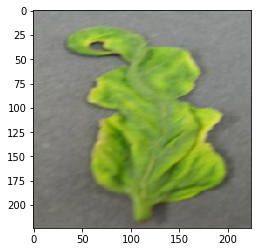

In [0]:
image_path = '/content/test/test'
cnn.pretrained_predict(image_path, num = 20)

# Train the Pretrained

Now, let's retrain the pretrained to adjust the classification.

Firstly, specify all the hyperparameters and image augmentation

In [0]:
# ====== Augmentation List ===========
# 'featurewise_center'              : False, 
# 'samplewise_center'               : False,
# 'featurewise_std_normalization'   : False, 
# 'samplewise_std_normalization'    : False,
# 'zca_whitening'                   : False, 
# 'zca_epsilon'                     : 1e-06, 
# 'rotation_range'                  : 0, 
# 'width_shift_range'               : 0.0,
# 'height_shift_range'              : 0.0, 
# 'brightness_range'                : None, 
# 'shear_range'                     : 0.0, 
# 'zoom_range'                      : 0.0,
# 'channel_shift_range'             : 0.0, 
# 'fill_mode'                       : 'nearest', 
# 'cval'                            : 0.0, 
# 'horizontal_flip'                 : False,
# 'vertical_flip'                   : False, 
# 'rescale'                         : None, 
# 'preprocessing_function'          : None,
# 'data_format'                     : None, 
# 'validation_split'                : 0.0, 
# 'dtype'                           : None        


augmentation = {
    'rescale'             : 1./255,
    'rotation_range'      : 40,
    'width_shift_range'   : 0.2,
    'height_shift_range'  : 0.2,
    'shear_range'         : 0.2,
    'zoom_range'          : 0.2,
    'horizontal_flip'     : True,
}

hyperparam = {
    'batch_size'    : 32, 
    'epochs'        : 20,
    'steps'         : 100,
    'val_steps'     : 80,
    'learning_rate' : 0.001,   
    'input_size'    : 224
}




Set up the data path. Please make sure inside the directory, there are `train` and `valid` folders, which each contains class directories containing images data.  

In [0]:
data_path = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'

In [0]:
cnn = TransferConvolutionalNetwork()

# cnn.augmentations = augmentation
# -- uncomment above line if want to use custom augmentation, 
# -- otherwise, only rescaling is going to be used

cnn.hyperparam = hyperparam

cnn.obtain_image_data(data_path)

cnn.set_pretrained_model(pretrained_lst[chosen], 
                        lastpool='avg', fine_tune_at=100,
                        feature_only=True)
cnn.add_hidden_layers([512])
cnn.set_output_layer()

cnn.show_summary()

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
29089792/29084464 [==============================] - 1s 0us/step
trainable layers: 328
total layers: 428
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
_________________________________________________________________________________________________

In [0]:
history = cnn.train(save=True)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.9233 - accuracy: 0.7384WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved/assets
100/100 [==============================] - 125s 1s/step - loss: 0.9233 - accuracy: 0.7384 - val_loss: 6.5849 - val_accuracy: 0.3059
Epoch 2/20
100/100 [==============================] - 123s 1s/step - loss: 0.4331 - accuracy: 0.8669 - val_loss: 1.1752 - val_accuracy: 0.7688
Epoch 3/20
100/100 [==============================] - 124s 1s/step - loss: 0.2994 - accuracy: 0.9069 - val_loss: 0.8215 - val_accuracy: 0.7918
Epoch 4/20
100/100 [==============================] - 124s 1s/step - loss: 0.2342 

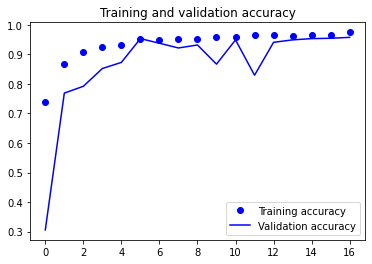

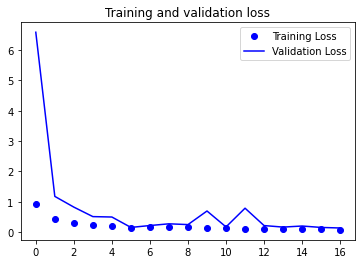

In [0]:
plot_accuracy(history)

In [0]:
cnn.predict('/content/test/test', 20)